In [87]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.is_available()
import torchvision
import torchvision.datasets as datasets
import time
import torch.jit as jit
from torch import nn
from torch import optim
import os
from scipy import io
import pickle
device='cuda'
torch.set_default_tensor_type(torch.FloatTensor)

from matplotlib import cm

In [116]:
def Mackey_Def(T_data,b=0.2,a=0.1,tau=17,delta=20):
    
    N_pred=20
    burn_in=20

    T_gen=2*(T_data+burn_in+N_pred)

    s=torch.zeros([T_gen])

    s[0:tau]=1.1*torch.rand([tau])+0.2

    for t in range(tau,T_gen):

        s[t]=s[t-1]+b*s[t-tau]/(1+s[t-tau]**delta)-a*s[t-1]
    
    S=s[np.arange(0,np.floor(T_gen/2))*2]
    
    Signal=S[burn_in:-N_pred]
    
    Y=torch.zeros([Signal.size()[0],N_pred])

    for n in range(0,N_pred):

        Y[:,n]=S[burn_in+n:-N_pred+n]
        
    return Signal, Y


def Sine_Task


In [117]:
class ESN(nn.Module):
    
    def __init__(self,N,N_in,N_av,alpha,rho,gamma):
        super().__init__()
        
        
        self.N=N
        self.alpha=torch.tensor(alpha).to(device)
        self.rho=rho
        self.N_av=N_av
        self.N_in=N_in
        self.gamma=gamma
        
        diluition=1-N_av/N
        W=np.random.uniform(-1,1,[N,N])
        W=W*(np.random.uniform(0,1,[N,N])>diluition)
        eig=np.linalg.eigvals(W)
        self.W=torch.from_numpy(self.rho*W/(np.max(np.absolute(eig)))).float().to(device)
        
        self.x=[]
        
        if self.N_in==1:
            
            self.W_in= 2*np.random.randint(0,2,[self.N_in,self.N])-1
            self.W_in=torch.from_numpy(self.W_in*self.gamma).float().to(device)
            
            
        else:
            
            self.W_in=np.random.randn(self.N_in,self.N)
            self.W_in=torch.from_numpy(self.gamma*self.W_in).float().to(device)
        
    def Reset(self,s):
        
        batch_size=np.shape(s)[0]
        self.x=torch.zeros([batch_size,self.N],device=device)
        
    def ESN_1step(self,s):
        
        self.x=(1-self.alpha)*self.x+self.alpha*torch.tanh(torch.matmul(s,self.W_in)+torch.matmul(self.x,self.W))
        
    def ESN_response(self,Input):
        
        T=Input.shape[2]
        X=torch.zeros(Input.shape[0],self.N,T)
        
        self.Reset(Input[:,0])
            
        for t in range(T):

            self.ESN_1step(Input[:,:,t])
            X[:,:,t]=torch.clone(self.x)

        return X

In [196]:
class Data_Manager():
     
        def __init__(self,Task_Id,T_data):
            
            self.Task_Id=Task_Id
                        
            if self.Task_Id=='MACKEY':
                
                S,Y=Mackey_Def(T_data)
                    
            self.S=S.clone().detach().unsqueeze(1).to(device)
            self.Y=Y.clone().detach().to(device)
            
            self.ESN=False
            
        def Init_ESN(self,N,N_in,N_av,alpha,rho,gamma):
            
            self.esn=ESN(N,N_in,N_av,alpha,rho,gamma)
            
        def ESN_Process(self):
                        
            s=torch.transpose(self.S,0,1).unsqueeze(0)
            
            X=self.esn.ESN_response(s)
            
            self.X=torch.transpose(X.squeeze(),0,1).to(device)
            
            self.ESN=True
        
        def Segmentation(self,T_seg):
            
            S_seg=torch.zeros([self.S.size()[0]-T_seg,T_seg],device=device)
            Y_shifted=torch.zeros([self.S.size()[0]-T_seg,self.Y.size()[1]],device=device)
            
            for t in range(T_seg):
                
                S_seg[:,t]=self.S[t:-T_seg+t,:].squeeze()
            
            Y_shifted=self.Y[T_seg-1:-1,:]
            
            self.S=S_seg
            self.Y=Y_shifted
        
        def Splitting(self,val_prc):
            
            N_val=int(np.floor(val_prc*self.S.size()[0]))
            N_te=N_val
            N_tr=self.S.size()[0]-2*N_val
            
            S_tr,S_val,S_te=torch.split(self.S,[N_tr,N_val,N_te])
            
            if self.ESN:
                
                X_tr,X_val,X_te=torch.split(self.X,[N_tr,N_val,N_te])
                
                self.X_tr=X_tr
                self.X_val=X_val
                self.X_te=X_te
                
            Y_tr,Y_val,Y_te=torch.split(self.Y,[N_tr,N_val,N_te])
            
            self.S_tr=S_tr
            self.S_val=S_val
            self.S_te=S_te
            
            self.Y_tr=Y_tr
            self.Y_val=Y_val
            self.Y_te=Y_te
            
        def Batch(self,batch_size,T_seq):
            
            rand_ind=torch.randint(0,self.S_tr.size()[0]-T_seq+1,[batch_size])
            
            if self.ESN:
                s=torch.zeros([batch_size,self.X_tr.size()[1],T_seq],device=device)
            else:
                s=torch.zeros([batch_size,self.S_tr.size()[1],T_seq],device=device)
            
            y=torch.zeros([batch_size,self.Y_tr.size()[1],T_seq],device=device)
            
            for n in range(batch_size):
                
                s[n,:,:]=torch.transpose(self.S_tr[rand_ind[n]:rand_ind[n]+T_seq,:],0,1)
                
                if self.ESN:
                    
                    s[n,:,:]=torch.transpose(self.X_tr[rand_ind[n]:rand_ind[n]+T_seq,:],0,1)
                
                y[n,:,:]=torch.transpose(self.Y_tr[rand_ind[n]:rand_ind[n]+T_seq,:],0,1)
                
            return s, y
        
        def Testing(self,Val=True):
            
            if Val==True:
                
                s=torch.transpose(self.S_val,0,1).unsqueeze(0)
                
                if self.ESN:
                    
                    s=torch.transpose(self.X_val,0,1).unsqueeze(0)
                    
                
                y=torch.transpose(self.Y_val,0,1).unsqueeze(0)
                
            else:
                
                s=torch.transpose(self.S_te,0,1).unsqueeze(0)
                
                if self.ESN:
                    
                    s=torch.transpose(self.X_te,0,1).unsqueeze(0)
                
                y=torch.transpose(self.Y_te,0,1).unsqueeze(0)
                
            return s, y
                                
                
                

[Text(0.5, 0, 'Step number'), Text(0, 0.5, 'Splitting')]

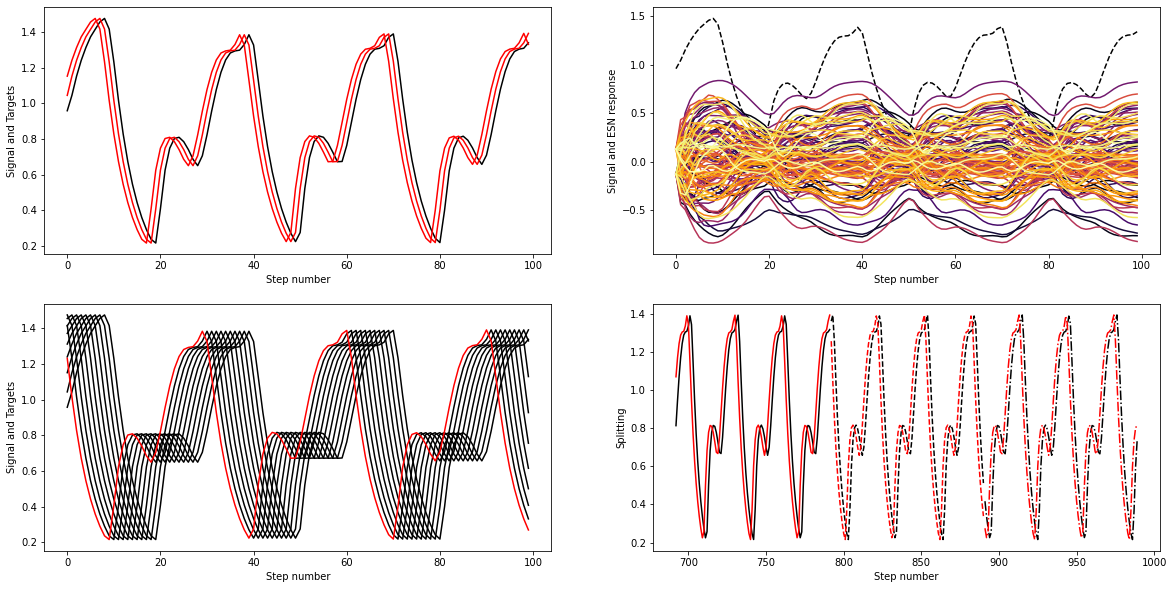

In [197]:
T_data=1000
Data=Data_Manager("MACKEY",T_data)

S_first=Data.S
Y_first=Data.Y

Data.Init_ESN(N=500, N_in=1, N_av=10, alpha=0.9, rho=0.99, gamma=0.15)

Data.ESN_Process()

X_esn=Data.X


Data.ESN=False
T_seg=10

Data.Segmentation(T_seg)

S_seg=Data.S
Y_seg=Data.Y

val_prc=0.1
Data.Splitting(val_prc)

S_tr=Data.S_tr
S_val=Data.S_val
S_te=Data.S_te

Y_tr=Data.Y_tr
Y_val=Data.Y_val
Y_te=Data.Y_te


fig, axs = plt.subplots(2, 2,figsize=(20,10))

N_y=3
T_plot=100

axs[0,0].plot(S_first[0:T_plot,:].to('cpu'),'black')

N_y=3
for n in range(1,N_y):
    axs[0,0].plot(Y_first[0:T_plot,n].to('cpu'),'red')
    
axs[0,0].set(xlabel='Step number',ylabel='Signal and Targets')


axs[0,1].plot(S_first[0:T_plot,:].to('cpu'), color='black', linestyle='dashed')

N_esn=100
cl=cm.inferno(np.linspace(0,1,N_esn))

for n in range(1,N_esn):
    axs[0,1].plot(X_esn[0:T_plot,n].to('cpu'),color=cl[n,:])
    
axs[0,1].set(xlabel='Step number',ylabel='Signal and ESN response')

for n in range(T_seg):
    axs[1,0].plot(S_seg[0:T_plot,n].to('cpu'),'black')

N_y=2
for n in range(1,N_y):
    axs[1,0].plot(Y_seg[0:T_plot,n].to('cpu'),'red')
    
axs[1,0].set(xlabel='Step number',ylabel='Signal and Targets')



ts_tr=torch.arange(0,S_tr.size()[0])
ts_val=torch.arange(S_tr.size()[0],S_tr.size()[0]+S_val.size()[0])
ts_te=torch.arange(S_tr.size()[0]+S_val.size()[0],S_tr.size()[0]+S_val.size()[0]+S_te.size()[0])

T_tr_plot=100
axs[1,1].plot(ts_tr[-T_tr_plot:].to('cpu'),S_tr.to('cpu')[-T_tr_plot:,-1],color='black')
axs[1,1].plot(ts_val.to('cpu'),S_val.to('cpu')[:,-1],'black',linestyle='dashed')
axs[1,1].plot(ts_te.to('cpu'),S_te.to('cpu')[:,-1],'black',linestyle='dashdot')

axs[1,1].plot(ts_tr[-T_tr_plot:].to('cpu'),Y_tr.to('cpu')[-T_tr_plot:,2],color='red')
axs[1,1].plot(ts_val.to('cpu'),Y_val.to('cpu')[:,2],linestyle='dashed',color='red')
axs[1,1].plot(ts_te.to('cpu'),Y_te.to('cpu')[:,2],linestyle='dashdot',color='red')

axs[1,1].set(xlabel='Step number',ylabel='Splitting')



In [212]:
class ODE_IntMethods:
    
    def __init__(self,F,dt):
        
        self.dt=dt
        self.F=F
        self.device='cuda'
    
    
    def RK2(self,X,I,t):
        
        k1=self.F(X,t,I)
        k2=self.F(X+k1*self.dt,t+self.dt,I)
        x_new=X+1/2*(k1+k2)*self.dt
        
        return x_new
    

    def RK4(self,X,I,t):
        
        k1=self.F(X,t,I)
        k2=self.F(X+k1*self.dt/2,t+self.dt/2,I)
        k3=self.F(X+k2*self.dt/2,t+self.dt/2,I)
        k4=self.F(X+k3*self.dt,t+self.dt,I)
        x_new=X+1/6*(k1+2*k2+2*k3+k4)*self.dt
        
        return x_new
    
    def Compute_Dynamics(self,Input,x0,t0):
        
        T=Input.size()[2]
        batch_size=x0.size()[0]
        N=x0.size()[1]
        
        X=torch.zeros([batch_size,N,T]).to(self.device)
        X[:,:,0]=x0
        
        t=t0
        
        for n in range(1,T):
            
            I=Input[:,:,n]

            X[:,:,n]=self.RK4(X[:,:,n-1],I,t)
                    
            
        return X
        
    


In [243]:
class MLP(nn.Module):
    
    def __init__(self,F_Ns):
        super().__init__()
                
        module=[]
        
        for n in range(1,F_Ns.size()[0]):
                        
            module.append(nn.Linear(F_Ns[n-1],F_Ns[n]))
        
            if n<F_Ns.size()[0]-1:
            
                module.append(nn.ReLU())
                
        self.F=nn.Sequential(*module)
        
        self.F_Ns=F_Ns
                    
    def forward(self,Input,t=[],S=[]):
        
        if S!=[]:
            
            Input=torch.concat([Input,S],1)
        
        y=self.F(Input)
        
        return y


class Model_Learning(nn.Module):
    
    def __init__(self, F_Ns, eta, weight_decay, N_ODE=False):
        super().__init__()    
        
        self.F_Ns=F_Ns
        
        self.N_ODE=N_ODE
        
        if N_ODE:
            
            dt=0.1
            self.f=MLP(F_Ns).to(device)
            self.F=ODE_IntMethods(self.f,dt)
        
        else:
            
            self.F=MLP(F_Ns).to(device)
        
        self.opt=optim.Adam( self.F.F.parameters(), lr=eta, weight_decay=weight_decay )
        
        self.loss=nn.MSELoss()
        
    def Reset(self,Input,t0s):
        
        self.X=Input
        self.t=t0s
        
    def SDE_step(self,Input):
        

        self.X=self.F.RK2(self.X,[],self.t)
        
    
    def forward(self,Input,y_true,t0s,Train_Last=True):
        
        T=Input.size()[2]
        batch_size=Input.size()[0]
        
        y=torch.zeros([batch_size,y_true.size()[1],T],device=device)
        
        err=0
        
        if self.N_ODE:
            
            self.Reset(Input[:,:,0],t0s)
        
        for t in range(T):
            
            if self.N_ODE:
                
                self.SDE_step([])
                y[:,:,t]=self.X.clone()
                
            else:
                
                y[:,:,t]=self.F(Input[:,:,t])
            
            #err=err+self.loss(y[:,:,t],y_true[:,:,t])/T
        
        err=torch.mean(torch.sum(torch.mean((y_true[:,:,:]-y[:,:,:])**2,1),1))
        
        err.backward(retain_graph=True)
        
        self.opt.step()
        self.opt.zero_grad()
        
        return err, y
        
        
    def Seqforward(self,Input,y_true,t0s,Train_Last=True):

        T=Input.size()[2]
        batch_size=Input.size()[0]

        y=torch.zeros([batch_size,y_true.size()[1],T],device=device)

        err=0
        
        with torch.no_grad():

            if self.N_ODE:

                self.Reset(Input[:,:,0],t0s)

            for t in range(T):

                if self.N_ODE:

                    self.SDE_step([])
                    y[:,:,t]=self.X.clone()


                else:

                    y[:,:,t]=self.F(Input[:,:,t])

                #err=err+self.loss(y[:,:,t],y_true[:,:,t])/T
            
            err=torch.mean(torch.sum(torch.mean((y_true[:,:,:]-y[:,:,:])**2,1),1))

        return err, y


            
    
    

In [255]:
T_data=1000
Data=Data_Manager("MACKEY",T_data)


Model_Id='MLP'
val_prc=0.1

if Model_Id=='ESN':
    
    N_ESN=500
    N_in=1
    N_av=10
    alpha=0.9
    rho=0.99
    gamma=0.15
    
    Data.Init_ESN(N_ESN, N_in, N_av, alpha, rho, gamma)
    Data.ESN_Process()
    Data.Splitting(val_prc)
    
    F_Ns=torch.tensor([N_ESN,Data.Y_tr.size()[1]])
    
    eta=0.0001
    weight_decay=0
    model=Model_Learning(F_Ns, eta, weight_decay)
    
    T_seq=1
    
if Model_Id=='MLP':
    
    T_seg=5
    Data.Segmentation(T_seg)
    Data.Splitting(val_prc)

    F_Ns=torch.tensor([Data.S_tr.size()[1],200,200,Y_tr.size()[1]])
    
    eta=0.001
    weight_decay=0
    model=Model_Learning(F_Ns, eta, weight_decay)
    
    T_seq=1
    
if Model_Id=='N_ODE':
    
    N_ODE=True
    
    T_seg=5
    Data.Segmentation(T_seg)
    Data.Splitting(val_prc)

    
    F_Ns=torch.tensor([Data.S_tr.size()[1],200,200,Data.S_tr.size()[1]])
    
    eta=0.001
    weight_decay=0
    model=Model_Learning(F_Ns, eta, weight_decay, N_ODE)
    
    T_seq=20
    
    

In [256]:
N_train=10000
N_checkpoint=500

N_check=int(np.ceil(N_train/N_checkpoint))
ind_help=0

N_chunks=1

MSE_Train=torch.zeros([N_train])

MSE_Tr=torch.zeros([N_check])
MSE_Val=torch.zeros([N_check])
MSE_Te=torch.zeros([N_check])

t0s=torch.tensor(0.)


for k in range(N_train):
    
    X_b, Y_b=Data.Batch(batch_size, T_seq)
    
    if model.N_ODE:

        var_help=X_b.clone()
        X_b=var_help[:,:,0:-1].clone()
        Y_b=var_help[:,:,1:]
    
    err,_=model.forward(X_b,Y_b,t0s)
    MSE_Train[k]=err.detach()
    
    if k%N_checkpoint==0: 
        
        
        if k>0:
            
            mse_mean=torch.mean(MSE_Train[k-N_checkpoint:k])
        
            MSE_Tr[ind_help]=mse_mean
            
        else:
            
            MSE_Tr[ind_help]=MSE_Train[k]
            
        
        ## VALIDATING ##
        #############
                            
        X_b,Y_b=Data.Testing()
        
        if model.N_ODE:
            
            var_help=X_b.clone()
            X_b=var_help[:,:,0:-1].clone()
            Y_b=var_help[:,:,1:]
        
        err_, y_=model.Seqforward(X_b,Y_b,t0s)
        
        MSE_Val[ind_help]=err_.detach()
        
        ## TESTING ##
        #############
        
        X_b,Y_b=Data.Testing(False)
        
        if model.N_ODE:
        
            var_help=X_b.clone()
            X_b=var_help[:,:,0:-1].clone()
            Y_b=var_help[:,:,1:]
        
        err_, y_=model.Seqforward(X_b,Y_b,t0s)
        
        MSE_Te[ind_help]=err_.detach()
        
        print('Errors: ', MSE_Tr[ind_help], MSE_Val[ind_help] , MSE_Te[ind_help])
        
        ind_help=ind_help+1

Errors:  tensor(0.8311) tensor(73.1393) tensor(76.3458)
Errors:  tensor(0.0469) tensor(0.8807) tensor(0.9186)
Errors:  tensor(0.0059) tensor(0.3105) tensor(0.3111)
Errors:  tensor(0.0032) tensor(0.2185) tensor(0.2221)
Errors:  tensor(0.0023) tensor(0.1348) tensor(0.1343)
Errors:  tensor(0.0017) tensor(0.0807) tensor(0.0791)
Errors:  tensor(0.0015) tensor(0.1066) tensor(0.1044)
Errors:  tensor(0.0013) tensor(0.0756) tensor(0.0768)
Errors:  tensor(0.0011) tensor(0.0714) tensor(0.0693)
Errors:  tensor(0.0011) tensor(0.0527) tensor(0.0544)
Errors:  tensor(0.0010) tensor(0.0328) tensor(0.0336)
Errors:  tensor(0.0009) tensor(0.0657) tensor(0.0639)
Errors:  tensor(0.0008) tensor(0.0274) tensor(0.0289)
Errors:  tensor(0.0008) tensor(0.0303) tensor(0.0307)
Errors:  tensor(0.0008) tensor(0.0334) tensor(0.0346)
Errors:  tensor(0.0006) tensor(0.0361) tensor(0.0367)
Errors:  tensor(0.0007) tensor(0.0446) tensor(0.0459)
Errors:  tensor(0.0007) tensor(0.0216) tensor(0.0215)
Errors:  tensor(0.0006) te

KeyboardInterrupt: 